In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Load data
train = pd.read_csv("train_volume_vix.csv", parse_dates=["date"])
test = pd.read_csv("test_volume_vix.csv", parse_dates=["date"])

# Drop missing values just in case
train = train.dropna(subset=["vix_close", "target_volume"])
test = test.dropna(subset=["vix_close", "target_volume"])



In [ ]:
# add time features to capture seasonality and trends

train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["dayofweek"] = train["date"].dt.dayofweek

test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["dayofweek"] = test["date"].dt.dayofweek

In [3]:
train.head()

,date,sh_volume,vix_close,target_volume,year,month,dayofweek
0,2004-01-02,3.213291e+09,18.22,4.529997e+09,2004,1,4
1,2004-01-05,4.529997e+09,17.49,4.308225e+09,2004,1,0
2,2004-01-06,4.308225e+09,16.73,4.697461e+09,2004,1,1
3,2004-01-07,4.697461e+09,15.50,5.293304e+09,2004,1,2
4,2004-01-08,5.293304e+09,15.61,4.770808e+09,2004,1,3


In [4]:
# Log-transform target and input to reduce scale effects
X_train = train[["vix_close", "year", "month", "dayofweek"]]
y_train = np.log(train["target_volume"])


X_test = test[["vix_close", "year", "month", "dayofweek"]]
y_test = np.log(test["target_volume"])

In [5]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [6]:
y_pred = model.predict(X_test)

In [7]:
# metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Squared Error: 0.0875400194671322
R^2 Score: -2.1973304829964944


In [8]:

# To get predictions back to original scale
y_pred_original_scale = np.exp(y_pred)
y_test_original_scale = np.exp(y_test)

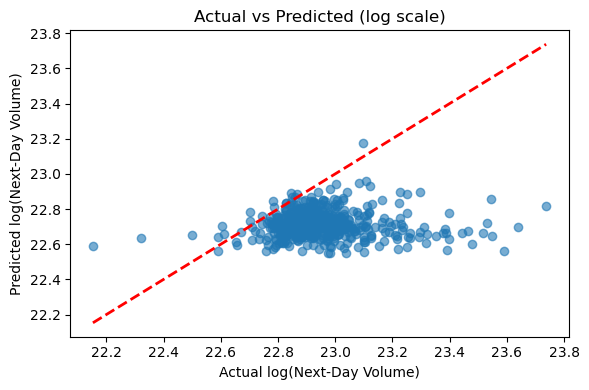

In [9]:
import matplotlib.pyplot as plt

# ---------- 1) Actual vs Predicted (log scale) ----------
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
minv, maxv = np.min([y_test.min(), y_pred.min()]), np.max([y_test.max(), y_pred.max()])
plt.plot([minv, maxv], [minv, maxv], 'r--', lw=2)
plt.xlabel("Actual log(Next-Day Volume)")
plt.ylabel("Predicted log(Next-Day Volume)")
plt.title("Actual vs Predicted (log scale)")
plt.tight_layout()
plt.show()

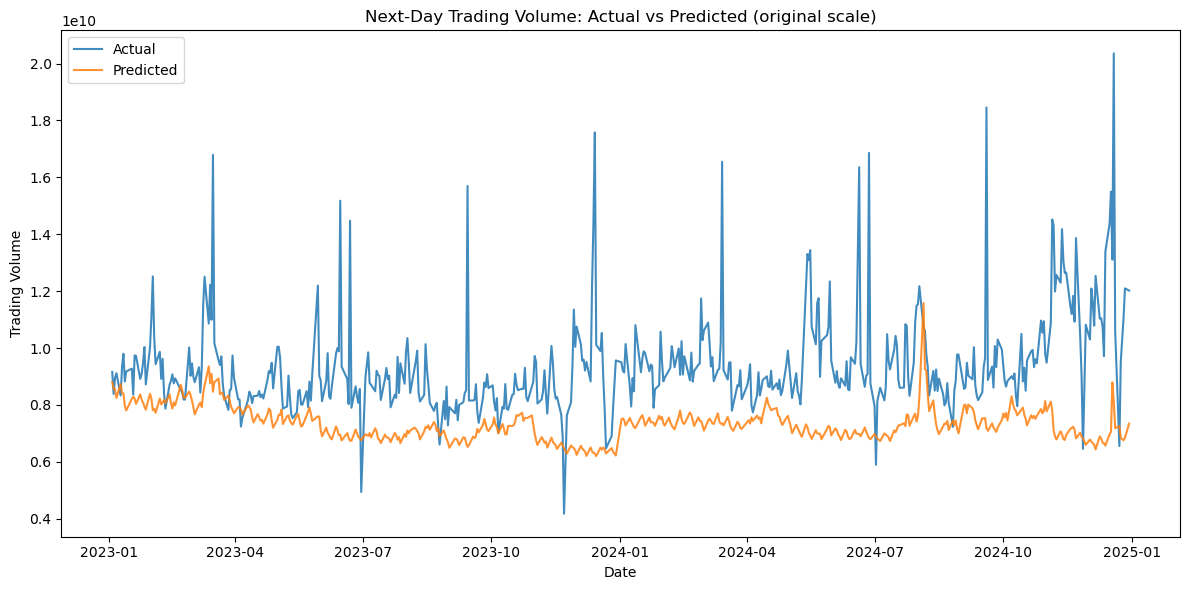

In [10]:
# ---------- 2) Time-series (original scale) ----------
actual = np.exp(y_test)
pred   = np.exp(y_pred)

plot_df = test.copy()
plot_df["actual_volume"] = actual
plot_df["predicted_volume"] = pred

plt.figure(figsize=(12,6))
plt.plot(plot_df["date"], plot_df["actual_volume"], label="Actual", alpha=0.85)
plt.plot(plot_df["date"], plot_df["predicted_volume"], label="Predicted", alpha=0.85)
plt.xlabel("Date"); plt.ylabel("Trading Volume")
plt.title("Next-Day Trading Volume: Actual vs Predicted (original scale)")
plt.legend(); plt.tight_layout(); plt.show()

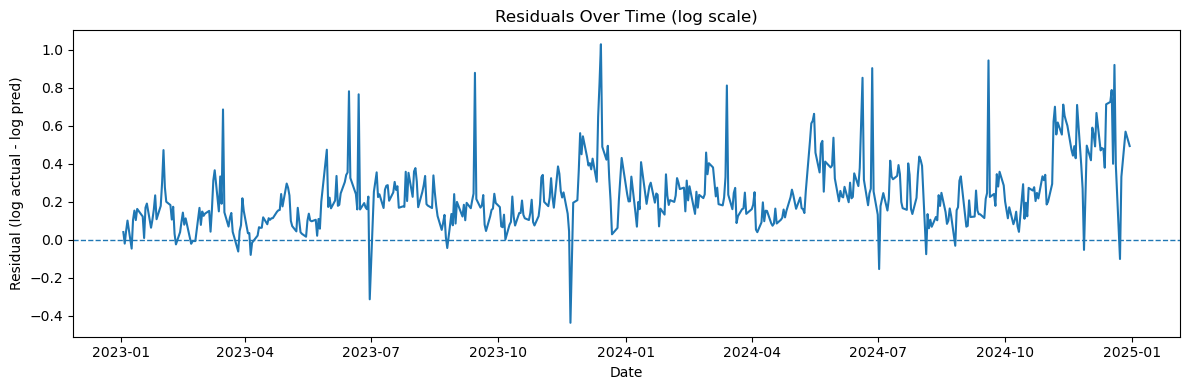

In [11]:
# ---------- 3) Residuals over time (log scale) ----------
resid = y_test - y_pred   # positive = underprediction on original scale
plt.figure(figsize=(12,4))
plt.plot(plot_df["date"], resid)
plt.axhline(0, ls="--", lw=1)
plt.xlabel("Date"); plt.ylabel("Residual (log actual - log pred)")
plt.title("Residuals Over Time (log scale)")
plt.tight_layout(); plt.show()